# Analysis of 2018 Songs

In [21]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
import xgboost as xgb
from plotnine import ggplot, aes, geom_point, geom_line, labs
!pip install pyreadr
import pyreadr

In [22]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Data processing

In [27]:
# Read data
data = pyreadr.read_r('song_data.rds')
data = data[None]

# Filter data for release year 2018
ml_data = data[data['release_year'] == '2018']
print(ml_data.shape)

# Group by tag and select top 1900 rows based on listen_times
ml_data = ml_data.groupby('tag').apply(lambda x: x.nlargest(1900, 'listen_times')).reset_index(drop=True)
print(ml_data.shape)

# Split data into train and test sets
ml_train = ml_data.groupby('tag').apply(lambda x: x.sample(frac=0.8, random_state=210016)).reset_index(drop=True)
ml_test = pd.concat([ml_data, ml_train]).drop_duplicates(keep=False).reset_index(drop=True)

# Select relevant columns for training and testing, select the chosen timbre characterics
ml_train = ml_train.iloc[:, [1] + list(range(6, 17))]
ml_test = ml_test.iloc[:, [1] + list(range(6, 17))]
print('ml train :\n', ml_train.head())
print('ml test :\n', ml_test.head())

(17165, 32)
(7600, 32)
ml train :
     tag  chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
0  folk          0.303014   0.125860                0.245976   
1  folk          0.319999   0.101217                0.120525   
2  folk          0.336855   0.291260                0.293755   
3  folk          0.372416   0.084773                0.391576   
4  folk          0.311357   0.305757                0.246503   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
0                 0.520390      0.354252                 0.100853    0.724109   
1                 0.341132      0.149137                 0.048511    0.653992   
2                 0.594479      0.443239                 0.118332    0.823460   
3                 0.699666      0.604665                 0.147331    0.739217   
4                 0.543373      0.371541                 0.087542    0.816105   

   mfcc2_norm  mfcc3_norm  mfcc4_norm  mfcc5_norm  
0    0.501996    0.512700    0.559616    

# Train classifiers

## Naive Bayes

In [5]:
# Train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])

# Predict on train set
p_train = nb_model.predict(ml_train.iloc[:, 1:])
print(p_train)
print(sum(p_train == ml_train.iloc[:, 0]) / len(p_train))

# Predict on test set
p_test = nb_model.predict(ml_test.iloc[:, 1:])
p_test_prob = nb_model.predict_proba(ml_test.iloc[:, 1:])
print(p_test)
print('Accuracy score of Naive Bayes :', round(sum(p_test == ml_test.iloc[:, 0]) / len(p_test),3))
print('AUC score of Naive Bayes :', round(roc_auc_score(ml_test.iloc[:, 0], p_test_prob, multi_class='ovr'),3))

['folk' 'folk' 'pop' ... 'folk' 'folk' 'pop']
0.46365131578947366
['folk' 'folk' 'folk' ... 'folk' 'folk' 'hiphop']
Accuracy score of Naive Bayes : 0.46
AUC score of Naive Bayes : 0.748


## K-Nearest Neighbors

In [6]:
df_knn_auc = pd.DataFrame(columns=['k', 'acc', 'auc'])
for k in range(1, 200):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
    knn_pred = knn_model.predict(ml_test.iloc[:, 1:])
    acc = sum(knn_pred == ml_test.iloc[:, 0]) / len(knn_pred)
    auc = roc_auc_score(ml_test.iloc[:, 0], knn_model.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')
    df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame.from_records([{'k': k, 'acc': acc, 'auc': auc}])])
    print(k)
df_knn_auc = df_knn_auc.sort_values(['acc','auc'], ascending=[False,False]).head(10)
print('KNN AUC score :\n', df_knn_auc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
KNN AUC score :
      k       acc       auc
0   68  0.590132  0.814548
0   72  0.590132  0.814220
0   70  0.589474  0.814491
0  116  0.589474  0.809425
0  117  0.589474  0.809311
0  124  0.588816  0.809336
0   60  0.588158  0.813972
0  108  0.588158  0.810916
0  118  0.588158  0.809241
0   66  0.587500  0.81458

## Random Forest

In [7]:
df_rf_auc = pd.DataFrame(columns=['n', 'max', 'acc', 'auc'])
for n in range(80, 101):
    for max_nodes in range(80, 101):
    #for max_nodes in range(98, 101):
        rf_model = RandomForestClassifier(n_estimators=n, max_depth=max_nodes)
        rf_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
        rf_pred = rf_model.predict(ml_test.iloc[:, 1:])
        acc = sum(rf_pred == ml_test.iloc[:, 0]) / len(rf_pred)
        auc = roc_auc_score(ml_test.iloc[:, 0], rf_model.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')
        df_rf_auc = pd.concat([df_rf_auc, pd.DataFrame.from_records([{'n': n, 'max': max_nodes, 'acc': acc, 'auc': auc}])])
        print('depth :',max_nodes)
    print('n :',n)
df_rf_auc = df_rf_auc.sort_values(['acc','auc'], ascending=[False,False]).head(10)
print(df_rf_auc.head())

depth : 80
depth : 81
depth : 82
depth : 83
depth : 84
depth : 85
depth : 86
depth : 87
depth : 88
depth : 89
depth : 90
depth : 91
depth : 92
depth : 93
depth : 94
depth : 95
depth : 96
depth : 97
depth : 98
depth : 99
depth : 100
n : 80
depth : 80
depth : 81
depth : 82
depth : 83
depth : 84
depth : 85
depth : 86
depth : 87
depth : 88
depth : 89
depth : 90
depth : 91
depth : 92
depth : 93
depth : 94
depth : 95
depth : 96
depth : 97
depth : 98
depth : 99
depth : 100
n : 81
depth : 80
depth : 81
depth : 82
depth : 83
depth : 84
depth : 85
depth : 86
depth : 87
depth : 88
depth : 89
depth : 90
depth : 91
depth : 92
depth : 93
depth : 94
depth : 95
depth : 96
depth : 97
depth : 98
depth : 99
depth : 100
n : 82
depth : 80
depth : 81
depth : 82
depth : 83
depth : 84
depth : 85
depth : 86
depth : 87
depth : 88
depth : 89
depth : 90
depth : 91
depth : 92
depth : 93
depth : 94
depth : 95
depth : 96
depth : 97
depth : 98
depth : 99
depth : 100
n : 83
depth : 80
depth : 81
depth : 82
depth : 83


## XGBoost

In [8]:
ml_train_num = ml_train.copy()
ml_train_num['tag'] = ml_train_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
ml_test_num = ml_test.copy()
ml_test_num['tag'] = ml_test_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
train_matrix = xgb.DMatrix(data=ml_train_num.iloc[:, 1:], label=ml_train_num.iloc[:, 0])
test_matrix = xgb.DMatrix(data=ml_test_num.iloc[:, 1:], label=ml_test_num.iloc[:, 0])
best_param = {}
best_seednumber = 1234
best_logloss = float('inf')
best_logloss_index = 0
for n in range(100):
    param = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 4,
        'max_depth': np.random.choice(range(2, 6)),
        'eta': np.random.uniform(0.01, 0.1),
        'gamma': np.random.uniform(0.0, 0.2),
        'subsample': np.random.uniform(0.6, 0.9),
        'colsample_bytree': np.random.uniform(0.5, 0.8),
        'min_child_weight': np.random.choice(range(1, 41)),
        'max_delta_step': np.random.choice(range(1, 11))
    }
    seed_number = np.random.randint(10000)
    cv_result = xgb.cv(param, train_matrix, num_boost_round=500, nfold=5, early_stopping_rounds=8, seed=seed_number)
    min_logloss = cv_result['test-mlogloss-mean'].min()
    min_logloss_index = cv_result['test-mlogloss-mean'].idxmin()
    if min_logloss < best_logloss:
        best_logloss = min_logloss
        best_logloss_index = min_logloss_index
        best_seednumber = seed_number
        best_param = param
    print(n)
nround = best_logloss_index
bst_model = xgb.train(best_param, train_matrix, num_boost_round=nround)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


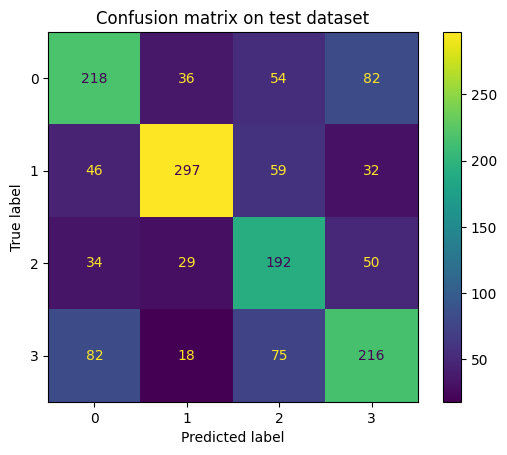

XGB AUC score: 0.584


In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set using XGBoost model
test_pred = bst_model.predict(test_matrix)
x_test_prediction = pd.DataFrame(test_pred).apply(lambda x: x.idxmax(), axis=1)
y_test_prediction = ml_test.iloc[:, 0].map({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})

# Display confusion matrix on test dataset
cm = confusion_matrix(x_test_prediction, y_test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion matrix on test dataset')
plt.show()

y_true = ml_test['tag'].to_numpy()
y_true = np.unique(y_true, return_inverse=True)[1]
print('XGB AUC score:', round(roc_auc_score(y_true, test_pred, multi_class='ovr'),3))

# Prediction

## Preprocess data for prediction

In [10]:
# data_predict = data[data['release_year'].isin([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
data_predict = data[data['release_year'].isin(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])]
data_predict['release_year'] = pd.to_datetime(data_predict['release_date']).dt.year
data_predict['tag_bin'] = data_predict['tag'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['treatment_date'] = (pd.to_datetime(data_predict['release_date']) < pd.to_datetime('2017-04-16'))
data_predict['treatment_year'] = (data_predict['release_year'] < 2017).astype(int)
print(data_predict.head())
x_data_predict = data_predict.iloc[:, 6:17]

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

<ipython-input-10-f8949bac3e51>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-10-f8949bac3e51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-10-f8949bac3e51>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-10-f8949bac3e51>

## Naive Bayes

In [11]:
data_predict['gnb_pred'] = nb_model.predict(x_data_predict)
data_predict['gnb_pred_acc'] = (data_predict['gnb_pred'] == data_predict['tag']).astype(int)
data_predict['gnb_pred_bin'] = data_predict['gnb_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['gnb_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['gnb_pred_bin']).astype(int)
print(data_predict.head())
print(data_predict.size)

<ipython-input-11-fb72780ba53f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-11-fb72780ba53f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-11-fb72780ba53f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-11-fb72780ba53f>

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

## K-Nearest Neighbors

In [12]:
data_predict['knn_pred'] = knn_model.predict(x_data_predict)
data_predict['knn_pred_acc'] = (data_predict['knn_pred'] == data_predict['tag']).astype(int)
data_predict['knn_pred_bin'] = data_predict['knn_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['knn_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['knn_pred_bin']).astype(int)
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

<ipython-input-12-08682c3cfeda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-12-08682c3cfeda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-12-08682c3cfeda>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-12-08682c3cfeda>

## Random Forest

In [13]:
data_predict['rf_pred'] = rf_model.predict(x_data_predict)
data_predict['rf_pred_acc'] = (data_predict['rf_pred'] == data_predict['tag']).astype(int)
data_predict['rf_pred_bin'] = data_predict['rf_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['rf_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['rf_pred_bin']).astype(int)
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

<ipython-input-13-d88161cf4afb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-13-d88161cf4afb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-13-d88161cf4afb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-13-d88161cf4afb>

## XGBoost

In [14]:
data_predict_xgb = bst_model.predict(xgb.DMatrix(x_data_predict))
#data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).apply(lambda x: x.idxmax(), axis=1)
data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).idxmax(axis=1)
data_predict['xgb_pred'] = data_predict['xgb_pred'].replace({0: 'pop', 1: 'hiphop', 2: 'rock', 3: 'folk'})
data_predict['xgb_pred_acc'] = (data_predict['xgb_pred'] == data_predict['tag']).astype(int)
data_predict['xgb_pred_bin'] = data_predict['xgb_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['xgb_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['xgb_pred_bin']).astype(int)
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

<ipython-input-14-e3972acdcd60>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-14-e3972acdcd60>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-14-e3972acdcd60>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-14-e3972acdcd60>

In [15]:
print(data_predict.columns)
data_predict.to_pickle('pickles/data_predict_2018.pkl')

Index(['song_id', 'tag', 'release_date', 'release_month', 'release_year',
       'listen_times', 'chroma_stft_norm', 'rmse_norm',
       'spectral_centroid_norm', 'spectral_bandwidth_norm', 'rolloff_norm',
       'zero_crossing_rate_norm', 'mfcc1_norm', 'mfcc2_norm', 'mfcc3_norm',
       'mfcc4_norm', 'mfcc5_norm', 'mfcc6_norm', 'mfcc7_norm', 'mfcc8_norm',
       'mfcc9_norm', 'mfcc10_norm', 'mfcc11_norm', 'mfcc12_norm',
       'mfcc13_norm', 'mfcc14_norm', 'mfcc15_norm', 'mfcc16_norm',
       'mfcc17_norm', 'mfcc18_norm', 'mfcc19_norm', 'mfcc20_norm', 'tag_bin',
       'treatment_date', 'treatment_year', 'gnb_pred', 'gnb_pred_acc',
       'gnb_pred_bin', 'gnb_pred_bin_acc', 'knn_pred', 'knn_pred_acc',
       'knn_pred_bin', 'knn_pred_bin_acc', 'rf_pred', 'rf_pred_acc',
       'rf_pred_bin', 'rf_pred_bin_acc', 'xgb_pred', 'xgb_pred_acc',
       'xgb_pred_bin', 'xgb_pred_bin_acc'],
      dtype='object')


# Display Metrics

## Naive Bayes

,release_year,treatment_year,gnb_pred_acc,gnb_pred_bin_acc,gnb_recall,gnb_precision
0,2009,1,0.249642,0.157368,0.703704,0.069343
1,2010,1,0.265951,0.202148,0.781022,0.154624
2,2011,1,0.262842,0.159563,0.787611,0.110973
3,2012,1,0.333625,0.211909,0.708487,0.188420
4,2013,1,0.285282,0.171035,0.684713,0.167969
5,2014,1,0.325967,0.188988,0.718905,0.256547
6,2015,1,0.333874,0.172612,0.726580,0.258027
7,2016,1,0.284222,0.167537,0.667845,0.207161
8,2017,0,0.349844,0.225467,0.753488,0.366667
9,2018,0,0.349840,0.249286,0.750275,0.423011


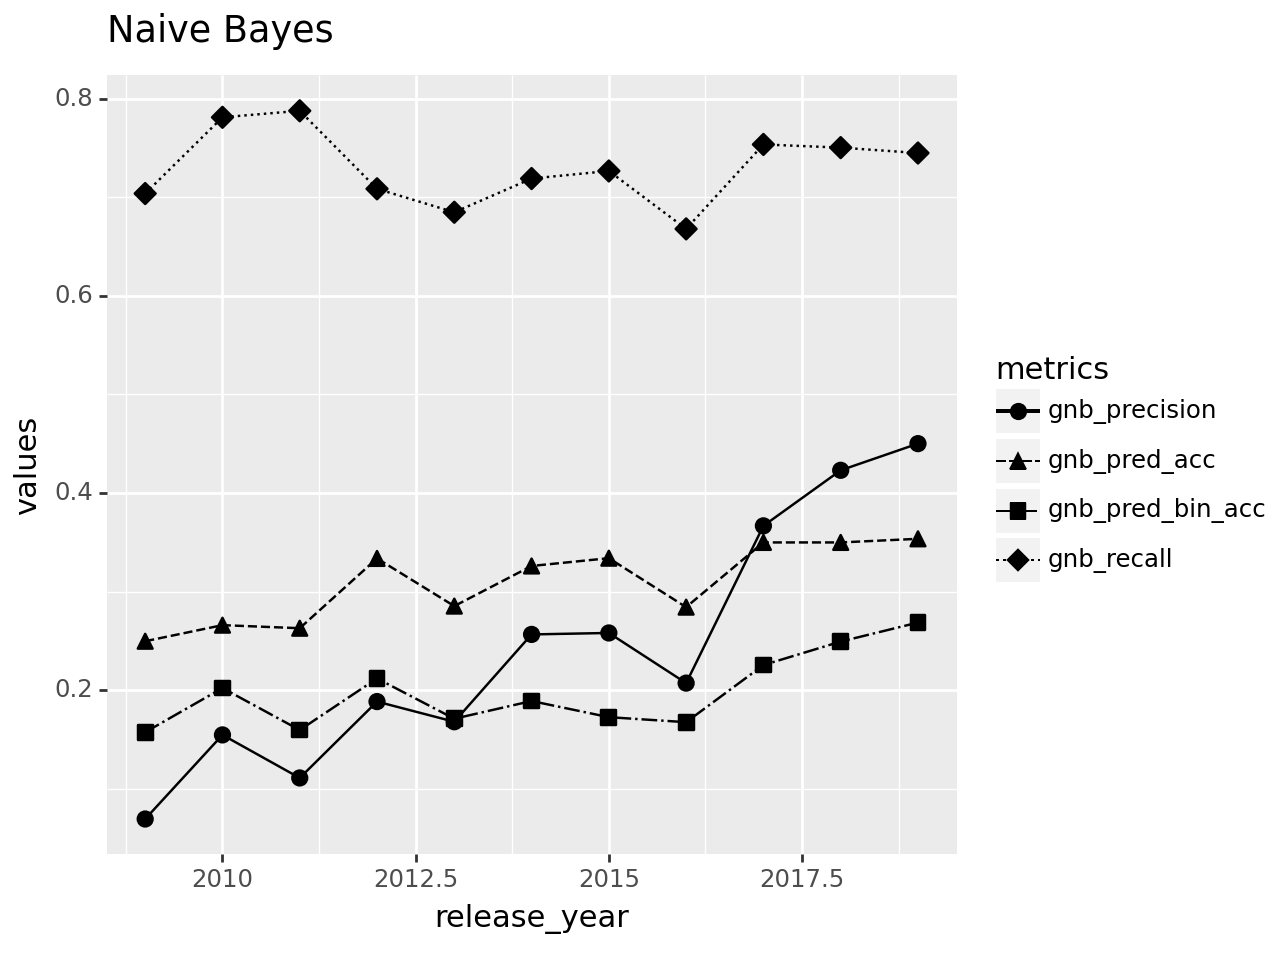

In [16]:
###### Mean Prediction 4 Tags Accuracy By Years ######
gnb_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index()
###### Mean Prediction Hip-Hop Binary Accuracy By Years ######
gnb_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['gnb_pred_bin_acc'].mean().reset_index()
###### Mean Prediction Hip-Hop Recall By Years ######
gnb_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_recall'})
###### Mean Prediction Hip-Hop Precision By Years ######
gnb_precision_tbyyear = data_predict[data_predict['gnb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_precision'})
###### Aggregating Graphics: Mean Acc, Mean Hip-Hop Acc, Trap, Non-Trap ######
gnb_metrics = pd.concat([gnb_mean_acc_tbyyear, gnb_mean_bin_acc_tbyyear['gnb_pred_bin_acc'], gnb_recall_tbyyear['gnb_recall'], gnb_precision_tbyyear['gnb_precision']], axis=1)
display(gnb_metrics)
gnb_metrics = gnb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
# Plot Metrics
gnb_metrics_plot = ggplot(gnb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="Naive Bayes") + geom_line(aes(linetype='metrics'))
print(gnb_metrics_plot)

gnb_metrics.to_pickle('pickles/gnb_metrics_2018.pkl')

## K-Nearest Neighbors

,release_year,treatment_year,knn_pred_acc,knn_pred_bin_acc,knn_recall,knn_precision
0,2009,1,0.489986,0.391273,0.666667,0.179104
1,2010,1,0.535692,0.443462,0.678832,0.326316
2,2011,1,0.477049,0.346995,0.637168,0.227129
3,2012,1,0.537215,0.387478,0.597786,0.334021
4,2013,1,0.480511,0.354839,0.665605,0.327074
5,2014,1,0.492475,0.315679,0.628109,0.440279
6,2015,1,0.470961,0.288915,0.638344,0.424638
7,2016,1,0.440627,0.308274,0.605418,0.341983
8,2017,0,0.505374,0.366121,0.710782,0.573329
9,2018,0,0.502826,0.392485,0.720022,0.615710


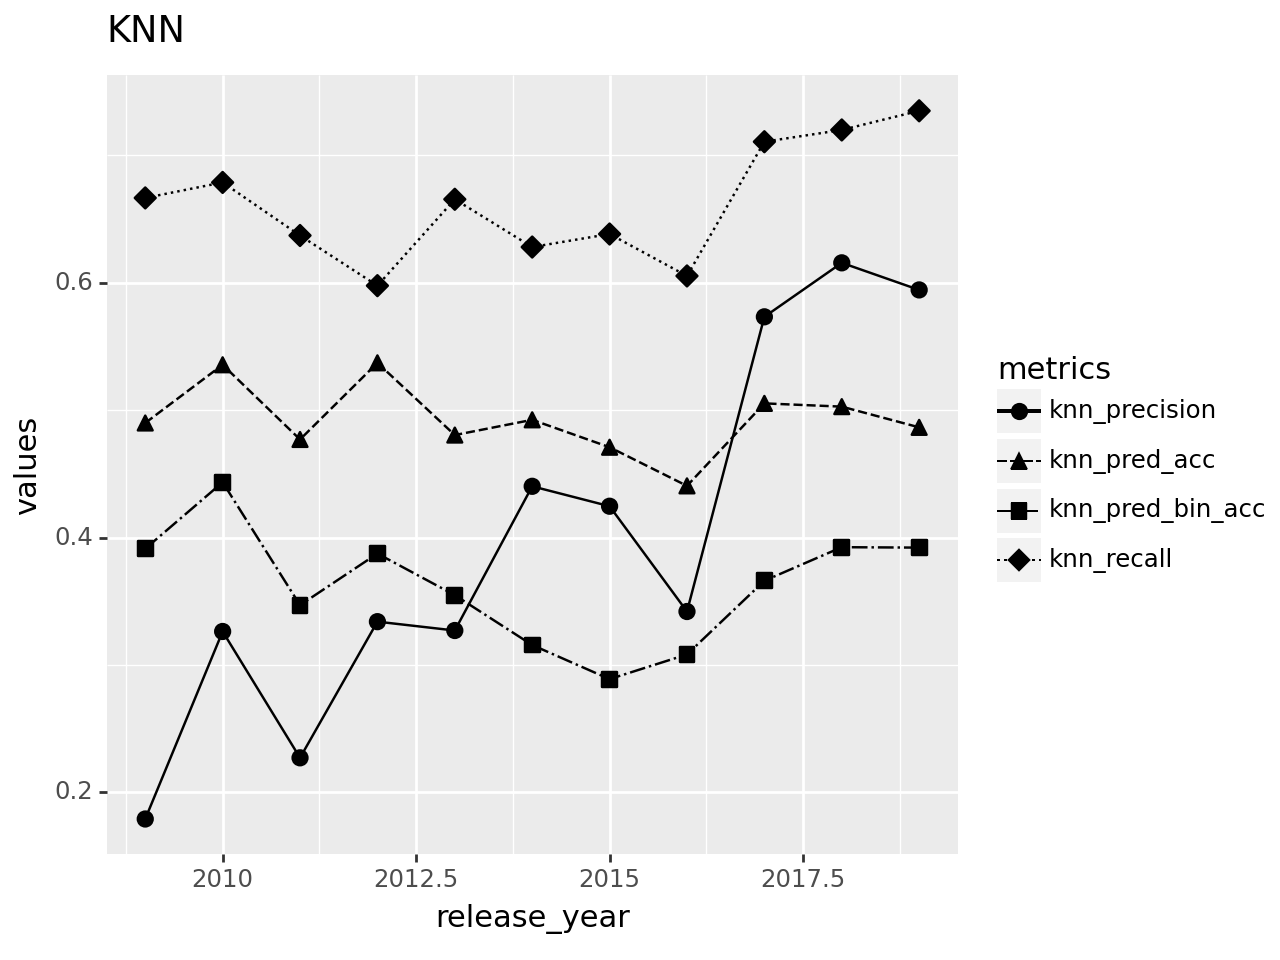

In [17]:
###### Mean Prediction 4 Tags Accuracy By Years ######
knn_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index()
###### Mean Prediction Hip-Hop Binary Accuracy By Years ######
knn_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_bin_acc'].mean().reset_index()
###### Prediction Hip-Hop Recall By Years ######
knn_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_recall'})
###### Prediction Hip-Hop Precision By Years ######
knn_precision_tbyyear = data_predict[data_predict['knn_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_precision'})
###### Aggregating Graphics: Mean Acc, Mean Hip-Hop Acc, Trap, Non-Trap ######
knn_metrics = pd.concat([knn_mean_acc_tbyyear, knn_mean_bin_acc_tbyyear['knn_pred_bin_acc'], knn_recall_tbyyear['knn_recall'], knn_precision_tbyyear['knn_precision']], axis=1)
display(knn_metrics)
knn_metrics = knn_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
# Plot Metrics
knn_metrics_plot = ggplot(knn_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="KNN") + geom_line(aes(linetype='metrics'))
print(knn_metrics_plot)

knn_metrics.to_pickle('pickles/knn_metrics_2018.pkl')

## Random Forest

,release_year,treatment_year,rf_pred_acc,rf_pred_bin_acc,rf_recall,rf_precision
0,2009,1,0.476395,0.357654,0.703704,0.201058
1,2010,1,0.523057,0.410613,0.700730,0.328767
2,2011,1,0.472131,0.319672,0.672566,0.250825
3,2012,1,0.540718,0.369089,0.634686,0.409524
4,2013,1,0.468414,0.314180,0.659236,0.361257
5,2014,1,0.496476,0.296818,0.661692,0.465849
6,2015,1,0.479953,0.271079,0.656863,0.450000
7,2016,1,0.440214,0.285871,0.638398,0.366464
8,2017,0,0.498053,0.345950,0.731078,0.577295
9,2018,0,0.658083,0.455345,0.870462,0.718991


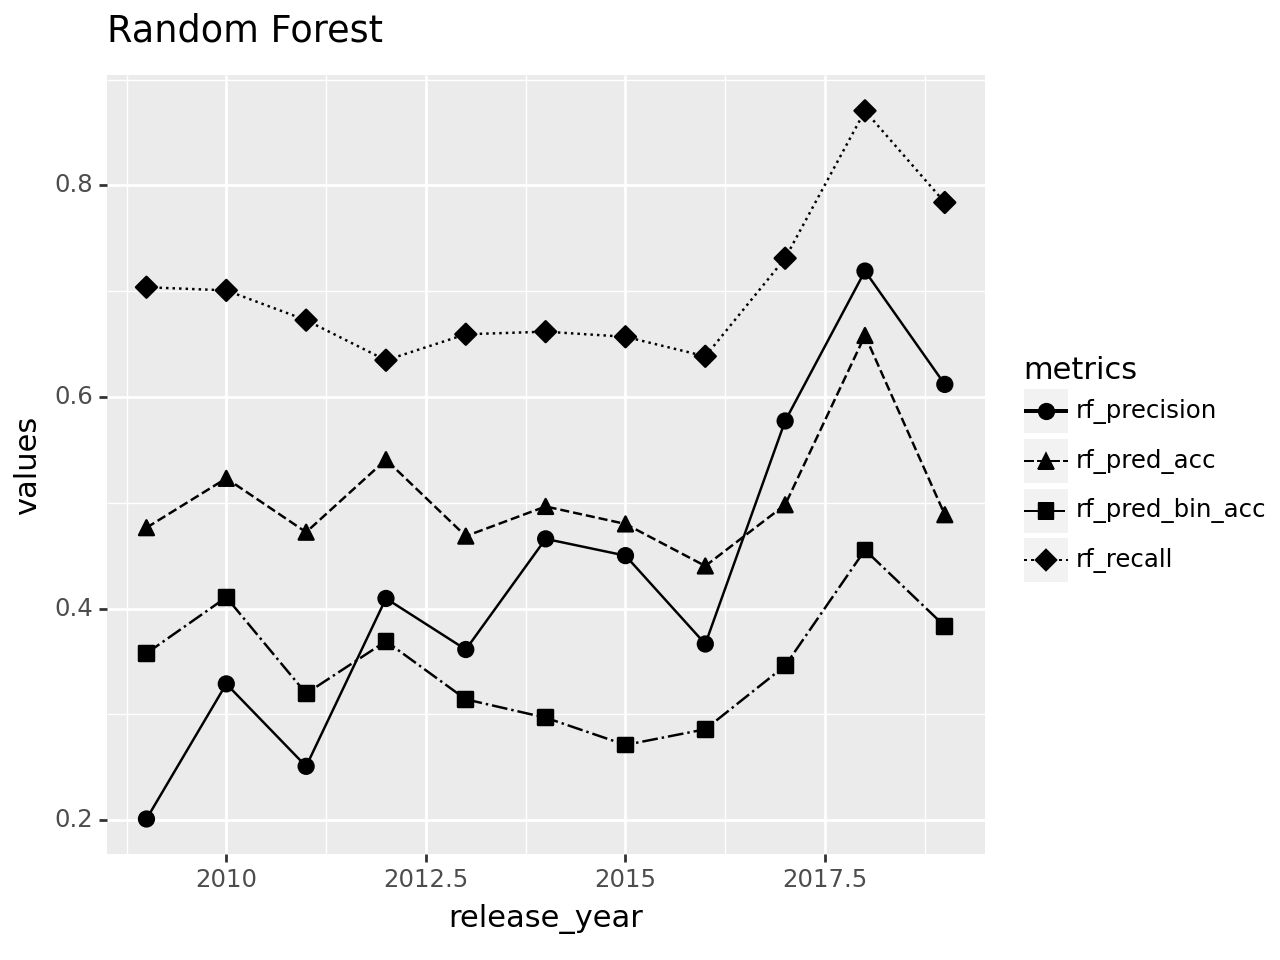

In [18]:
###### Mean Prediction 4 Tags Accuracy By Years ######
rf_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index()
###### Mean Prediction Hip-Hop Binary Accuracy By Years ######
rf_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['rf_pred_bin_acc'].mean().reset_index()
###### Prediction Hip-Hop Recall By Years ######
rf_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_recall'})
###### Prediction Hip-Hop Precision By Years ######
rf_precision_tbyyear = data_predict[data_predict['rf_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_precision'})
###### Aggregating Graphics: Mean Acc, Mean Hip-Hop Acc, Trap, Non-Trap ######
rf_metrics = pd.concat([rf_mean_acc_tbyyear, rf_mean_bin_acc_tbyyear['rf_pred_bin_acc'], rf_recall_tbyyear['rf_recall'], rf_precision_tbyyear['rf_precision']], axis=1)
display(rf_metrics)
rf_metrics = rf_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
# Plot Metrics
rf_metrics_plot = ggplot(rf_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="Random Forest") + geom_line(aes(linetype='metrics'))
print(rf_metrics_plot)

rf_metrics.to_pickle('pickles/rf_metrics_2018.pkl')

## XGBoost

,release_year,treatment_year,xgb_pred_acc,xgb_pred_bin_acc,xgb_recall,xgb_precision
0,2009,1,0.230329,0.185265,0.203704,0.044534
1,2010,1,0.209097,0.169931,0.145985,0.067568
2,2011,1,0.232787,0.164481,0.159292,0.055215
3,2012,1,0.193520,0.147548,0.114391,0.082447
4,2013,1,0.205309,0.158266,0.101911,0.067941
5,2014,1,0.192037,0.130501,0.093284,0.092937
6,2015,1,0.193249,0.118956,0.104575,0.086331
7,2016,1,0.197361,0.139500,0.101296,0.073254
8,2017,0,0.190265,0.135981,0.099789,0.116543
9,2018,0,0.196854,0.155899,0.089934,0.123489


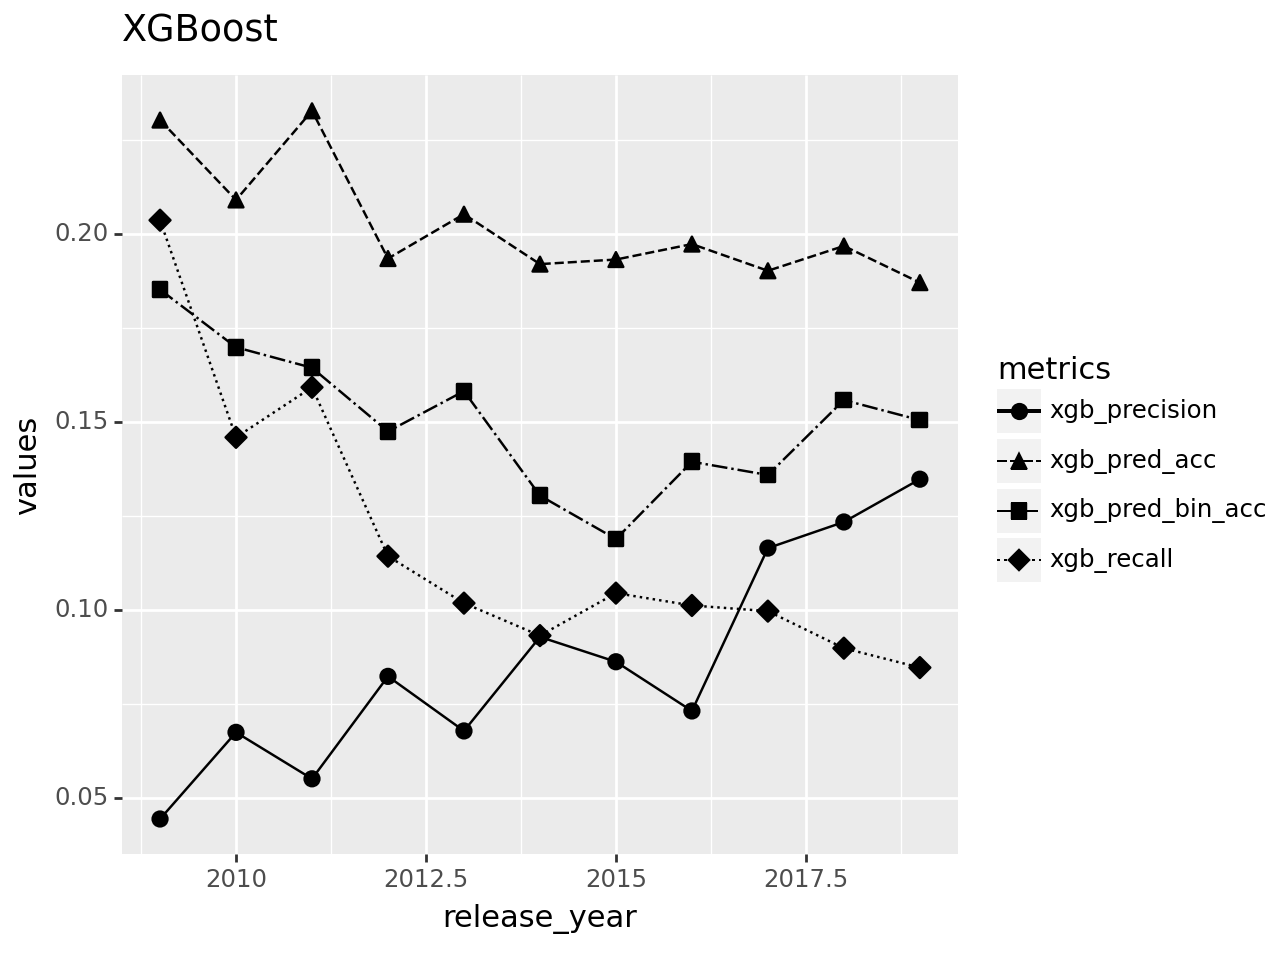

In [19]:
###### Mean Prediction 4 Tags Accuracy By Years ######
xgb_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
###### Mean Prediction Hip-Hop Binary Accuracy By Years ######
xgb_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
###### Mean Prediction Hip-Hop Recall By Years ######
xgb_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
###### Mean Prediction Hip-Hop Precision By Years ######
xgb_precision_tbyyear = data_predict[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
###### Aggregating Graphics: Mean Acc, Mean Hip-Hop Acc, Trap, Non-Trap ######
xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
display(xgb_metrics)
xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
# Plot Metrics
xgb_metrics_plot = ggplot(xgb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="XGBoost") + geom_line(aes(linetype='metrics'))
print(xgb_metrics_plot)

xgb_metrics.to_pickle('pickles/xgb_metrics_2018.pkl')

## Average Four Classifiers

,release_year,treatment_year,metrics,values
0,2009,1,classifiers_pred_acc,0.361588
1,2010,1,classifiers_pred_acc,0.383449
2,2011,1,classifiers_pred_acc,0.361202
3,2012,1,classifiers_pred_acc,0.401270
4,2013,1,classifiers_pred_acc,0.359879
5,2014,1,classifiers_pred_acc,0.376738
6,2015,1,classifiers_pred_acc,0.369509
7,2016,1,classifiers_pred_acc,0.340606
8,2017,0,classifiers_pred_acc,0.385884
9,2018,0,classifiers_pred_acc,0.426901


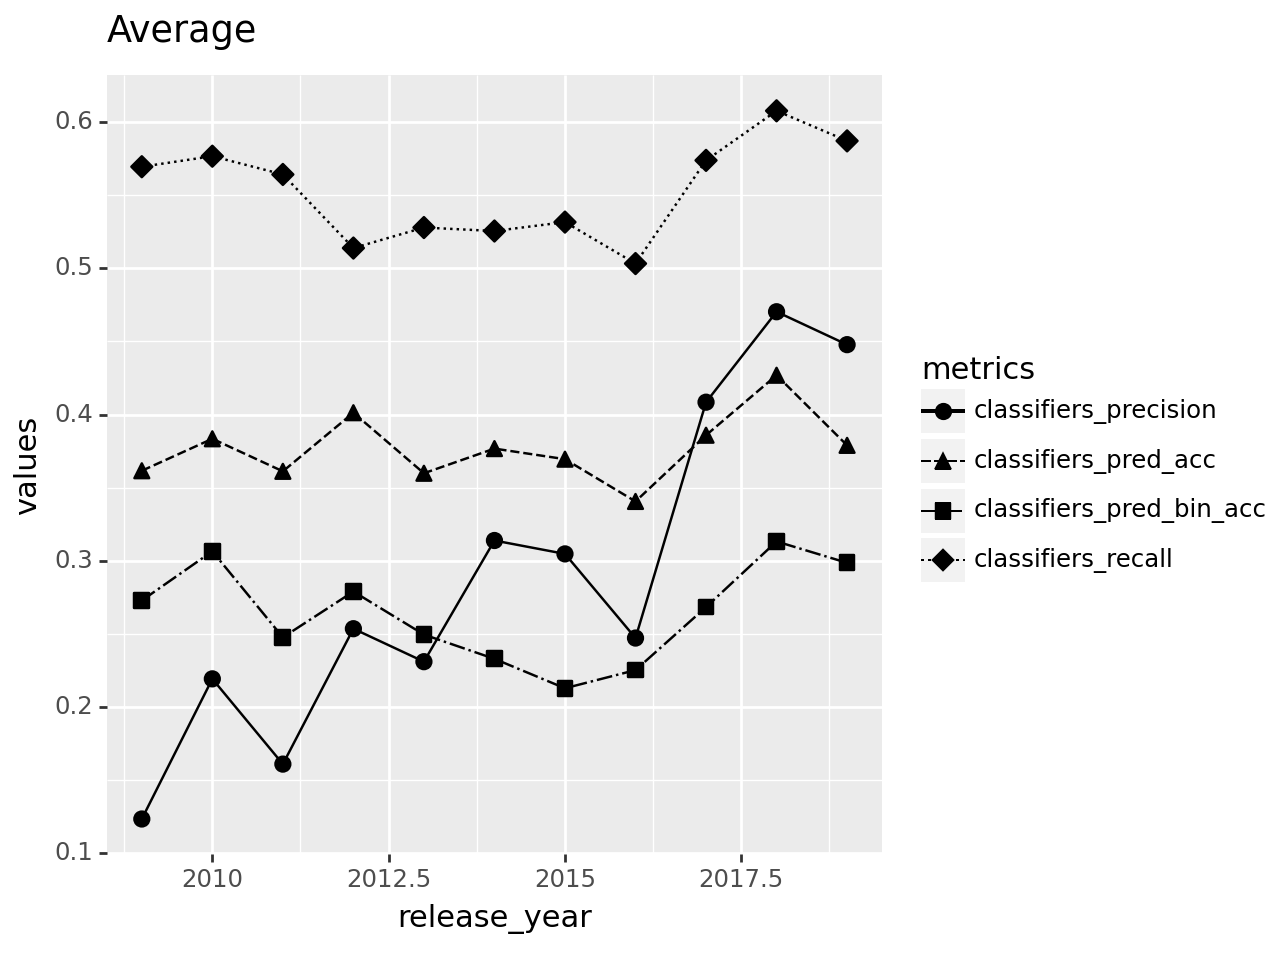

In [20]:
average = pd.concat([gnb_metrics['values'], knn_metrics['values'], rf_metrics['values'], xgb_metrics['values']], names = ['values', 'values_1', 'values_2', 'values_3'], axis=1)
average = average.mean(axis=1)
average = pd.concat([gnb_metrics['release_year'], gnb_metrics['treatment_year'], gnb_metrics['metrics'], average],axis=1)
average['metrics'] = average['metrics'].str.replace('gnb_', 'classifiers_')
average = average.rename(columns={0: "values"})
average.to_pickle('pickles/classifiers_metrics_2018.pkl')
display(average)

average_plot = ggplot(average, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="Average") + geom_line(aes(linetype='metrics'))
print(average_plot)